In [87]:
import os
os.environ["OMP_NUM_THREADS"] = str(1)
#os.environ["MKL_NUM_THREADS"] = str(1)

In [49]:
import baccoemu
import chainconsumer
import dynesty
import gc
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from multiprocessing import Pool, cpu_count
import tensorflow as tf
import torch

import emcee
import os
import pandas as pd
import time

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import sbi_tools
import plot_utils
#import scripts
# from scripts import sbi_tools
#from scripts import plot_utils
import generate_emuPks as genP

from momentnetworks import demo

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
n_threads = 24
tf.config.threading.set_inter_op_parallelism_threads(n_threads)
tf.config.threading.set_intra_op_parallelism_threads(n_threads)
# note: does NOT work to call sbi_tools.set_N_threads for some reason, need to do it here
torch.set_num_threads(n_threads)

RuntimeError: Inter op parallelism cannot be modified after initialization.

In [2]:
plot_dir = '../plots/plots_2024-03-11'
save_plots = True

In [3]:
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))
os.environ["OMP_NUM_THREADS"] = "1"

48 CPUs


In [4]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'
#N_threads = sbi_tools.set_N_threads(6)

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 

### Load data

In [90]:
tag_fit = '_cosmolib_err1p_kmax0.1'
run_moment = True
run_sbi = False
run_emcee = False
run_dynesty = True


In [6]:
param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']
param_names = ['omega_cold', 'sigma_8', 'h']
param_names_fixed = [name for name in param_names_all if name not in param_names]
idxs_param_names = [param_names_all.index(name) for name in param_names]

tag_pk = '_b1000'
dir_pks = f'../data/pks_cosmolib/pks{tag_pk}'

bias_params = np.loadtxt(f'{dir_pks}/bias_params.txt')

n_lib = 500
dir_mocks = '../data/cosmolib'
theta = []
Pk = []
gaussian_error_pk = []
param_dict_fixed = {}
for idx_LH in range(n_lib):
    fn_fields = f'{dir_mocks}/LH{idx_LH}/Eulerian_fields_lr_{idx_LH}.npy'
    fn_params = f'{dir_mocks}/LH{idx_LH}/cosmo_{idx_LH}.txt'
    fn_pk = f'{dir_pks}/pk_{idx_LH}.npy'
    
    pk_obj = np.load(fn_pk, allow_pickle=True).item()
    Pk.append(pk_obj['pk'])
    gaussian_error_pk.append(pk_obj['pk_gaussian_error'])
    
    param_vals = np.loadtxt(fn_params)
    if idx_LH==0:
        for name in param_names_fixed:
            param_dict_fixed[name] = param_vals[param_names_all.index(name)]
    theta.append(param_vals[idxs_param_names])

Pk = np.array(Pk)
theta = np.array(theta)
gaussian_error_pk = np.array(gaussian_error_pk)

kk = pk_obj['k'] # all ks should be same so just grab one

In [57]:
param_label_dict = {'omega_cold': r'$\Omega_\mathrm{m}$',
                'sigma8_cold': r'$\sigma_{8}$',
                'sigma_8': r'$\sigma_{8}$',
                'hubble': r'$h$',
                'h': r'$h$',
                'ns': r'$n_\mathrm{s}$',
                'n_s': r'$n_\mathrm{s}$',
                'omega_baryon': r'$\Omega_\mathrm{b}$',}
param_labels = [param_label_dict[param_name] for param_name in param_names]

In [7]:
n_tot = theta.shape[0]
n_params = theta.shape[1]

Plot P(k) data:

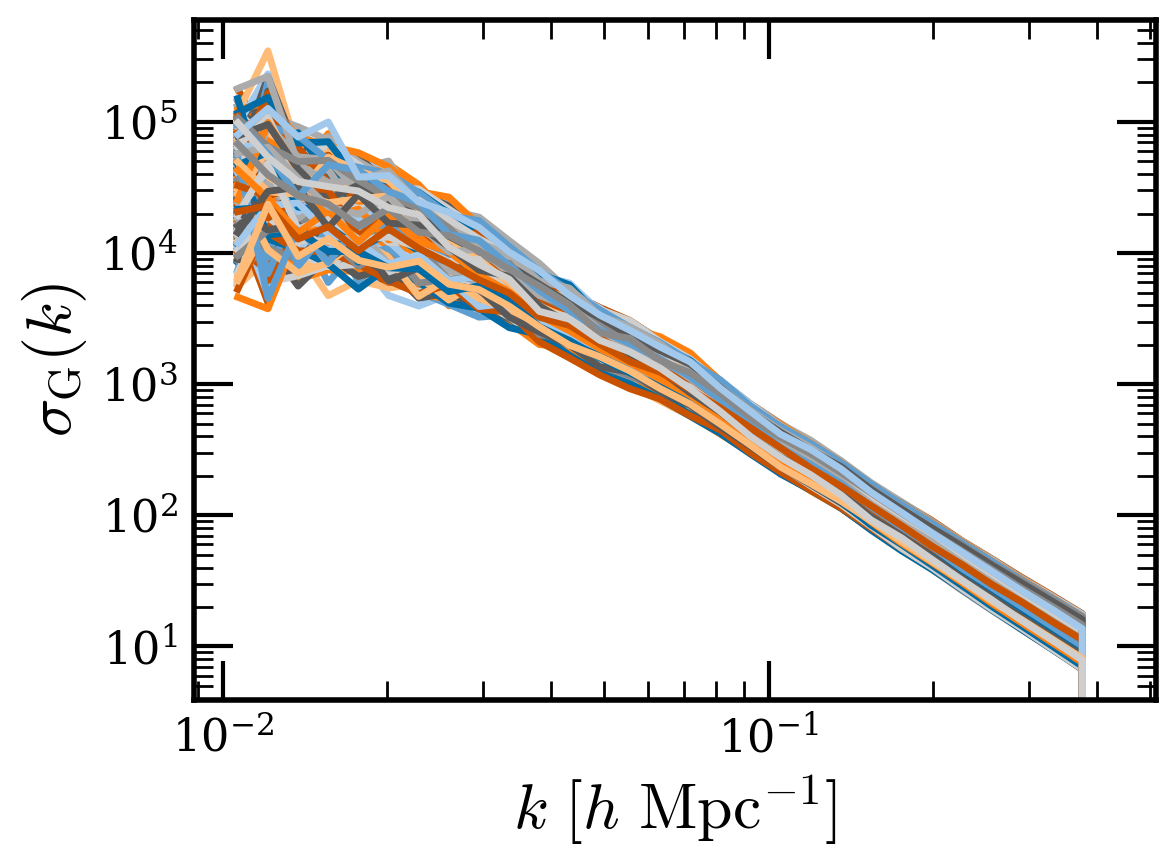

In [8]:
fig, ax = mpl.pyplot.subplots(figsize=(6, 4.5))
for iLH in range(n_tot):
    ax.loglog(kk, gaussian_error_pk[iLH])

ax.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=23)
ax.set_ylabel(r'$\sigma_\text{G}(k)$', fontsize=23)

mpl.pyplot.tight_layout()
mpl.pyplot.show()

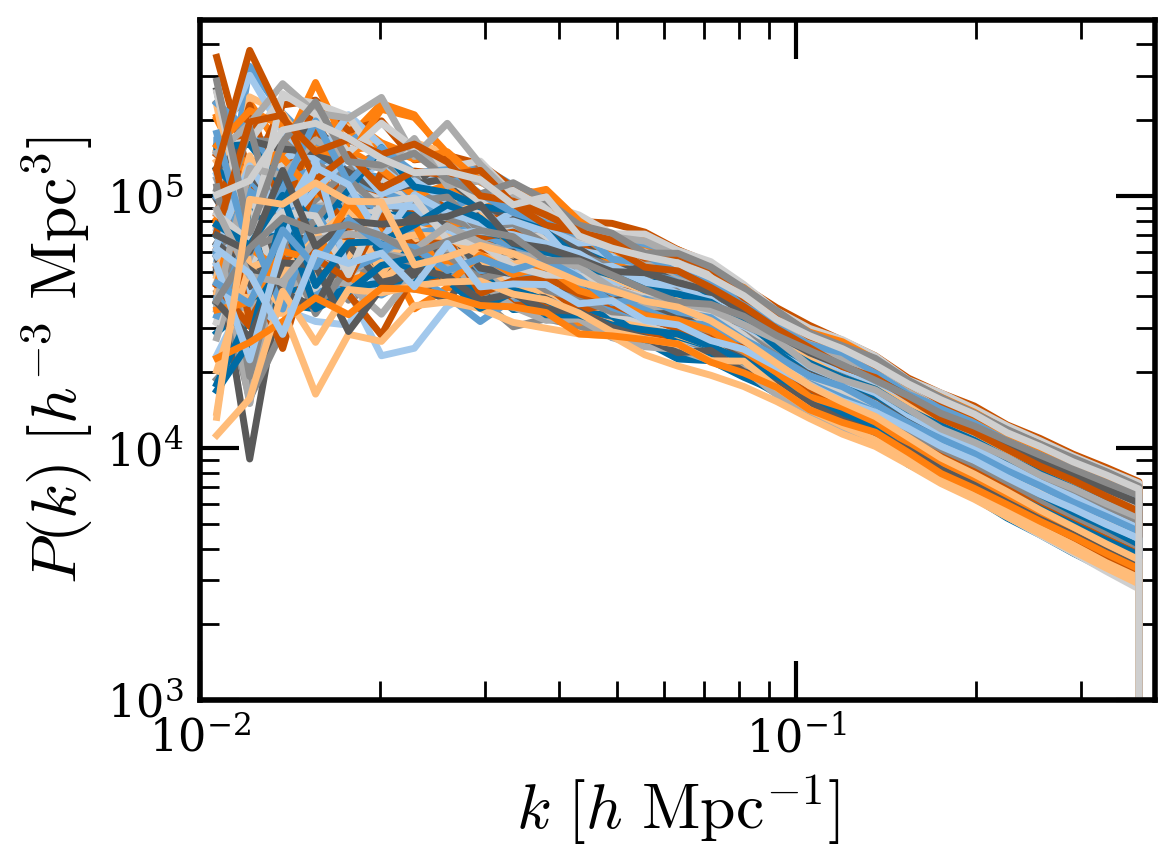

In [16]:
fig, ax = mpl.pyplot.subplots(figsize=(6, 4.5))
n_plot = 100
for iLH in range(n_plot):
    ax.loglog(kk, Pk[iLH])

ax.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=23)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=23)

ax.set_xlim(1e-2, 0.4)
ax.set_ylim(1e3, 5e5)

mpl.pyplot.tight_layout()
mpl.pyplot.show()

In [10]:
#n_biasmodels = len(biases_vec)
n_biasmodels = 0
n_cosmos = n_params
print(n_biasmodels, n_cosmos)

0 3


Split into train-val-test

In [11]:
p_train, p_test = 0.8, 0.1
p_val = 1-p_train-p_test
train_split = int(theta.shape[0]*p_train)
test_split = int(theta.shape[0]*(1-p_test))
#train_val_split = int(n_biasmodels*round(theta.shape[0]*0.99/n_biasmodels))

theta_train = theta[:train_split]
theta_val = theta[train_split:test_split]
theta_test = theta[test_split:]
print(theta_train.shape, theta_val.shape, theta_test.shape)

(400, 3) (50, 3) (50, 3)


In [12]:
Pk_train = Pk[:train_split]
Pk_val = Pk[train_split:test_split]
Pk_test = Pk[test_split:]

mask = np.all(Pk_train>0, axis=0)

# ADDING k max MASK
#mask_kmax = kk<0.1
#mask = mask & mask_kmax

Pk_train = Pk_train[:,mask]
Pk_val = Pk_val[:,mask]
Pk_test = Pk_test[:,mask]
k = kk[mask]

gaussian_error_pk_train = gaussian_error_pk[:train_split][:,mask]
gaussian_error_pk_val = gaussian_error_pk[train_split:test_split][:,mask]
gaussian_error_pk_test = gaussian_error_pk[test_split:][:,mask]

In [13]:
n_dim = Pk_train.shape[1]
print(n_tot, n_params, n_dim)

500 3 29


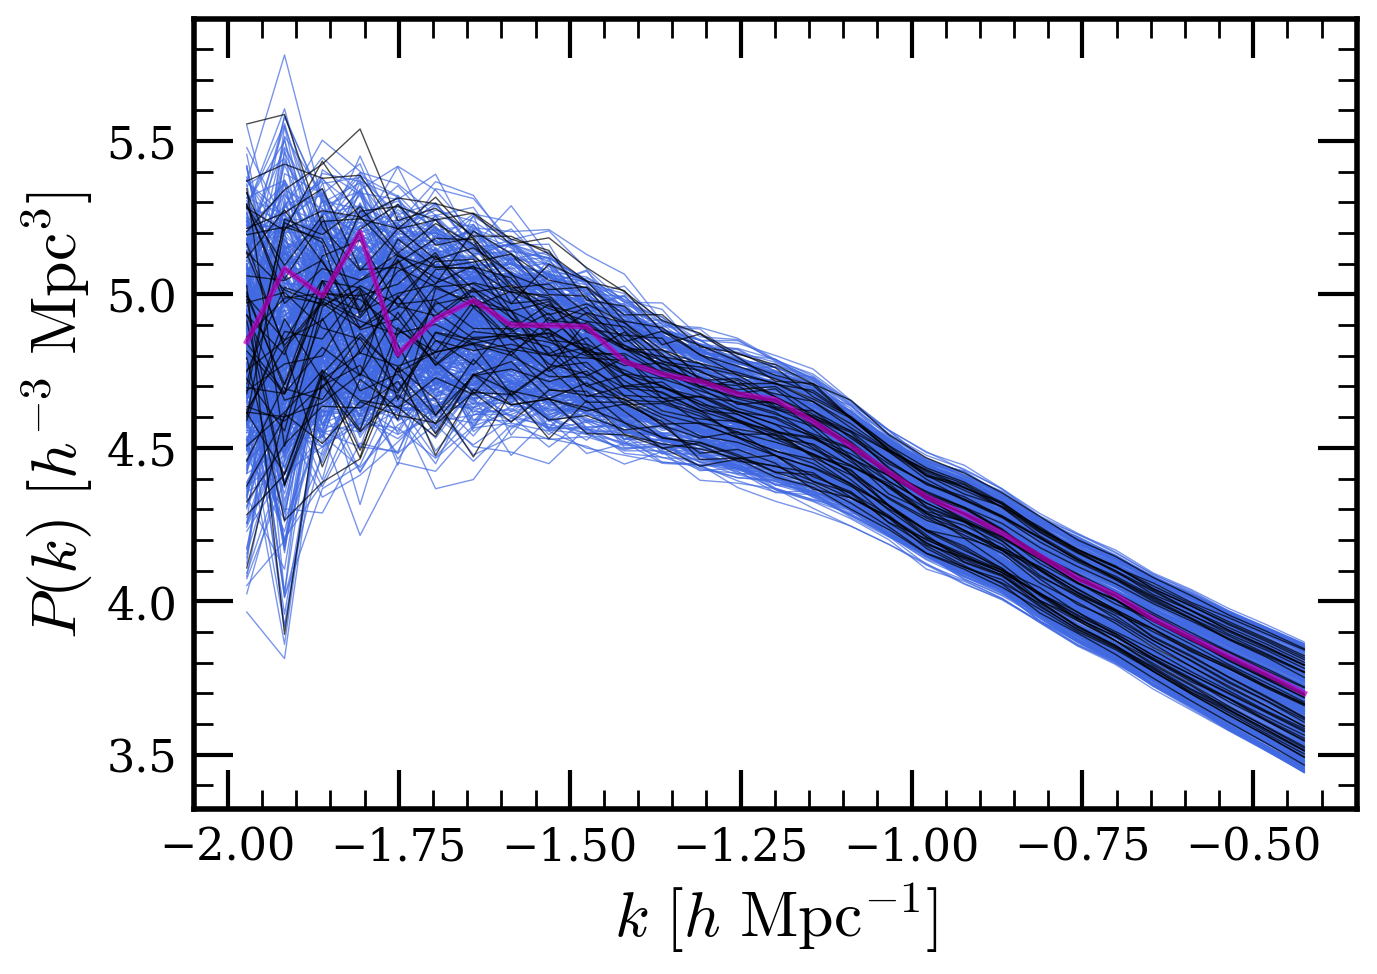

In [14]:
# fig, ax = mpl.pyplot.subplots(1,1, figsize=(7,5))
# fontsize = 24
# fontsize1 = 18

# alpha = 0.7

# tmp_Pk_plot = Pk_train
# tmp_Pk_plot = tmp_Pk_plot[np.random.choice(tmp_Pk_plot.shape[0], tmp_Pk_plot.shape[0], replace=False)].T
# ax.plot(np.log10(k), np.log10(tmp_Pk_plot), c='royalblue', alpha=alpha, lw=0.5, label='training set')

# tmp_Pk_plot = Pk_test
# tmp_Pk_plot = tmp_Pk_plot[np.random.choice(tmp_Pk_plot.shape[0], tmp_Pk_plot.shape[0], replace=False)].T
# ax.plot(np.log10(k), np.log10(tmp_Pk_plot), c='k', alpha=alpha, lw=0.5, label='test set')
    
# ax.plot(np.log10(k), np.log10(Pk_test[0]), c='m', alpha=alpha, lw=2, label='test data')
    
# ax.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=23)
# ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=23)

# mpl.pyplot.tight_layout()
# mpl.pyplot.show()

In [17]:
dict_bounds = {}
for pp, param_name in enumerate(param_names):
    dict_bounds[param_name] = [np.min(theta[:,pp]), np.max(theta[:,pp])]

In [38]:
class Scaler:

    def __init__(self, func='log_minmax'):
        self.func = func
        
    def fit(self, x_train):
        self.x_train_min = np.min(x_train, axis=0)
        self.x_train_max = np.max(x_train, axis=0)

    def scale(self, x):
        if self.func=='log_minmax':
            return self.scale_log_minmax(x)
        elif self.func=='minmax':
            return self.scale_minmax(x)
        else:
            raise ValueError(f"Function {self.func} not recognized")

    def unscale(self, x):
        if self.func=='log_minmax':
            return self.unscale_log_minmax(x)
        elif self.func=='minmax':
            return self.unscale_minmax(x)
        else:
            raise ValueError(f"Function {self.func} not recognized")
       
    def scale_error(self, err, x):
        if self.func=='log_minmax':
            return self.scale_error_log_minmax(err, x)
        elif self.func=='minmax':
            raise ValueError(f"Error not implemented for {self.func}")
        else:
            raise ValueError(f"Function {self.func} not recognized")

    def scale_log_minmax(self, x):
        log_x = np.log10(x)
        log_x_norm = (log_x - np.log10(self.x_train_min)) / (np.log10(self.x_train_max) - np.log10(self.    x_train_min))
        return log_x_norm
    
    def unscale_log_minmax(self, x_scaled):
        x = x_scaled * (np.log10(self.x_train_max) - np.log10(self.x_train_min)) + np.log10(self.x_train_min)
        return 10**x  
        
    def scale_error_log_minmax(self, err, x):
        # need 1/np.log(10) factor bc working in base 10
        dydx = 1./x * 1/np.log(10) * 1./(np.log10(self.x_train_max) - np.log10(self.x_train_min))
        err_scaled = np.sqrt(np.multiply(dydx**2, err**2))
        return err_scaled
    
    def scale_log(self, x):
        return np.log10(x)
    
    def scale_log_error(self, err, x):
        return (1./x) * (1/np.log(10)) * err
    
    def scale_minmax(self, x):
        return (x - self.x_train_min) / (self.x_train_max - self.x_train_min)
    
    def unscale_minmax(self, x_scaled):
        return x_scaled * (self.x_train_max - self.x_train_min) + self.x_train_min

ok gaussian error is not the same here...! check how bacco is measuring

In [39]:
scaler = Scaler()
scaler.fit(Pk_train)
Pk_train_scaled = scaler.scale(Pk_train)
Pk_val_scaled = scaler.scale(Pk_val)
Pk_test_scaled = scaler.scale(Pk_test)

gaussian_error_pk_train_scaled = scaler.scale_error(gaussian_error_pk_train, Pk_train)
gaussian_error_pk_val_scaled = scaler.scale_error(gaussian_error_pk_val, Pk_val)
gaussian_error_pk_test_scaled = scaler.scale_error(gaussian_error_pk_test, Pk_test)

In [40]:
print(np.min(Pk_train), np.max(Pk_train))
print(np.min(Pk_train_scaled), np.max(Pk_train_scaled))

print(np.min(Pk_test), np.max(Pk_test))
print(np.min(Pk_test_scaled), np.max(Pk_test_scaled))

2766.2477971575117 602915.102676903
0.0 1.0
2929.070891322468 385683.4217143961
0.040066188460055045 1.0714624091507088


In [41]:
print(Pk_train.shape, theta_train.shape, n_params)

(400, 29) (400, 3) 3


In [42]:
err_extra = 0.2*np.std(Pk_train, axis=0)
err_extra_scaled = scaler.scale_error(err_extra, np.median(Pk_train, axis=0))    
print(err_extra)

[11225.61715272 14902.78004104 10053.30694836  9993.42175074
  8449.65070866  7819.89732184  6624.38191309  5651.64521825
  4886.48346705  3894.77234015  3255.16186726  2605.13560923
  2255.23850974  2044.20942922  1839.1527548   1603.8863274
  1277.48807782  1024.20448447   863.56364513   778.52078852
   673.98062224   572.95061471   501.84363134   446.96848754
   394.31470627   354.16758854   318.11245794   287.9646804
   260.04054555]


### Set up emulator, visualize

In [23]:
def setup_cosmo_emu():
    print("Setting up emulator cosmology")
    cosmo_params = {
        #'omega_cold'    :  Om,
        #'sigma8_cold'   :  sigma8, # if A_s is not specified
        'omega_baryon'  :  param_dict_fixed['omega_baryon'],
        'ns'            :  param_dict_fixed['n_s'],
        #'hubble'        :  hubble,
        'neutrino_mass' :  0.0,
        'w0'            : -1.0,
        'wa'            :  0.0,
        'expfactor'     :  1
    }
    return cosmo_params

In [24]:
param_names_2_emu_param_names = {'sigma_8': 'sigma8_cold',
                                 'omega_cold': 'omega_cold',
                                 'h': 'hubble',
                                 'n_s': 'ns'}
emu_param_names = [param_names_2_emu_param_names[param_name] for param_name in param_names]

In [25]:
#emu = baccoemu.Lbias_expansion(verbose=False)
fn_emu = '/dipc_storage/cosmosims/data_share/lbias_emulator/lbias_emulator2.0.0'
emu = baccoemu.Lbias_expansion(verbose=False, 
                               nonlinear_emu_path=fn_emu,
                               nonlinear_emu_details='details.pickle',
                               nonlinear_emu_field_name='NN_n',
                               nonlinear_emu_read_rotation=False)
cosmo_params = setup_cosmo_emu()

Loading l-bias lpt emulator...


/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
2024-03-12 03:07:57.077993: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 48. Tune using inter_op_parallelism_threa

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...


/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.1.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Nonlinear l-bias emulator loaded in memory.
HIIII
Setting up emulator cosmology


/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [26]:
# overall quantities
deltas_pk_per_err = []
deltas_pk_per_err_scaled = []
for i in range(Pk_train.shape[0]):
    if i % 100 == 0:
        print(i)
    for pp in range(len(param_names)):
        cosmo_params[emu_param_names[pp]] = theta[i][pp]
    _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
                                                        **cosmo_params)
    # in this case the orig emu pks are what we want
    #pk_model_unscaled = Pk_noiseless[:train_split][i]
    delta_pk_per_err = (pk_model_unscaled-Pk_train[i])/gaussian_error_pk_train[i]
    deltas_pk_per_err.append(delta_pk_per_err)
    
    pk_model = scaler.scale(pk_model_unscaled)
    delta_pk_per_err_scaled = (pk_model-Pk_train_scaled[i])/gaussian_error_pk_train_scaled[i]
    deltas_pk_per_err_scaled.append(delta_pk_per_err_scaled)
    
deltas_pk_per_err = np.array(deltas_pk_per_err)
delta_pk_per_err_16 = np.percentile(deltas_pk_per_err, 16, axis=0)
delta_pk_per_err_84 = np.percentile(deltas_pk_per_err, 84, axis=0)

deltas_pk_per_err_scaled = np.array(deltas_pk_per_err_scaled)
deltas_pk_per_err_scaled_16 = np.percentile(deltas_pk_per_err_scaled, 16, axis=0)
deltas_pk_per_err_scaled_84 = np.percentile(deltas_pk_per_err_scaled, 84, axis=0)

0
100
200
300


In [31]:
delta_pk_per_err_std = np.std(deltas_pk_per_err, axis=0)
deltas_pk_per_err_scaled_std = np.std(deltas_pk_per_err_scaled, axis=0)

In [76]:
idx_test = 29
pk_data = Pk_test_scaled[idx_test]

[<matplotlib.collections.PolyCollection object at 0x2b0be085fc90>, <matplotlib.collections.PolyCollection object at 0x2b0be086d7d0>] ['16-84 percentile of training set', '$0.01*P_\\text{train}(k)$']


Text(0, 0.5, '$(P_\\text{emu}-P_\\text{data})/\\sigma_\\text{G}$')

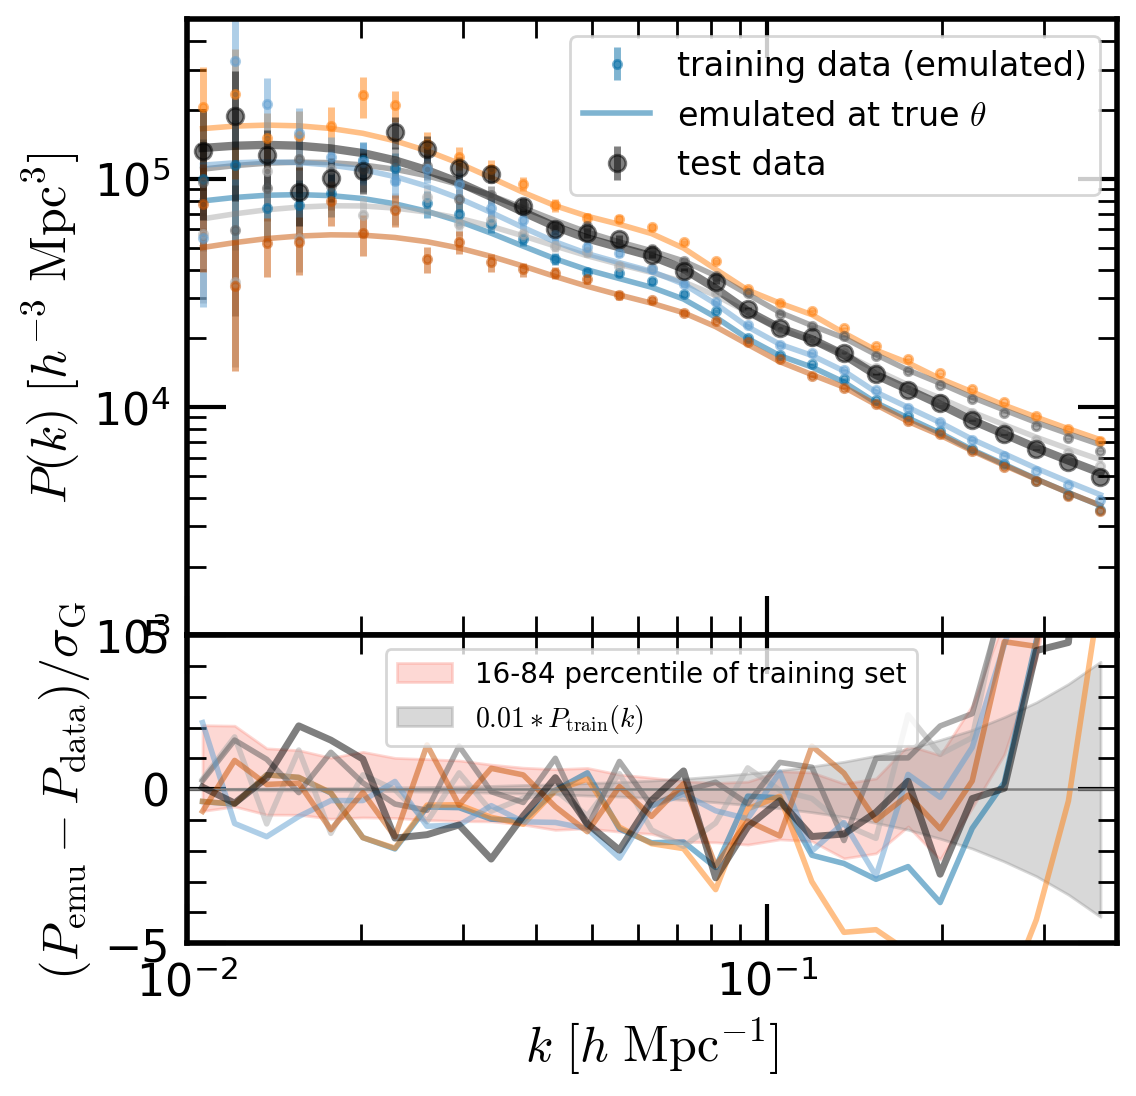

In [77]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,6), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0)
    
    
# a few examples
#colors = ['red', 'orange', 'green', 'blue', 'purple']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
lw = 2
show_error_all = True
for i in range(6):
    for pp in range(len(param_names)):
        cosmo_params[emu_param_names[pp]] = theta[i][pp]
    _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
                                                        **cosmo_params)
    #in this case the orig emu pks are what we want
    #pk_model_unscaled = Pk_noiseless_train[i]
    
    label_true, label_emu, label_stdev = None, None, None
    if i==0:
        label_true = 'training data (emulated)'
        label_emu = r'emulated at true $\theta$'
        label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
    
    if i==0 or show_error_all:
        axarr[0].errorbar(k, Pk_train[i], yerr=gaussian_error_pk_train[i], 
                          ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
    else:
        axarr[0].plot(k, Pk_train[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
    
    axarr[0].plot(k, pk_model_unscaled, ls='-', alpha=0.5, label=label_emu, color=colors[i], lw=lw)

    axarr[1].plot(k, (pk_model_unscaled-Pk_train[i])/gaussian_error_pk_train[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
    axarr[1].axhline(0, color='grey', lw=0.5)

axarr[1].fill_between(k, delta_pk_per_err_16, delta_pk_per_err_84, color='salmon', alpha=0.3,
                     label='16-84 percentile of training set')
# axarr[1].fill_between(k, -delta_pk_per_err_std, delta_pk_per_err_std, color='salmon', alpha=0.3,
#                       label=r'$\sigma$ of training set')
err_m2m = 0.01*Pk_train[i]
axarr[1].fill_between(k, -err_m2m/gaussian_error_pk_train[i], 
                            err_m2m/gaussian_error_pk_train[i], color='grey', alpha=0.3,
                            label=r'$0.01*P_\text{train}(k)$')

# test data
color_test = 'k'
for pp in range(len(param_names)):
    cosmo_params[emu_param_names[pp]] = theta_test[idx_test][pp]
_, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
                                                 **cosmo_params)
# in this case the orig emu pks are what we want
#pk_model_unscaled = Pk_noiseless_test[idx_test]
axarr[0].plot(k, pk_model_unscaled, ls='-', alpha=0.5, color=color_test, lw=3)
axarr[0].errorbar(k, Pk_test[idx_test], yerr=gaussian_error_pk_test[idx_test], 
                  ls='None', marker='o', markersize=6, alpha=0.5, label=f'test data', color=color_test)
axarr[1].plot(k, (pk_model_unscaled-Pk_test[idx_test])/gaussian_error_pk_test[idx_test], ls='-', alpha=0.5, color=color_test)

# plot settings
plt.xscale('log')
axarr[0].set_yscale('log')
    
plt.xlim(1e-2, 0.4)
axarr[0].set_ylim(1e3, 5e5)
axarr[1].set_ylim(-5, 5)
    
handles, labels = axarr[0].get_legend_handles_labels()
order = [1,0,2]
axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
# axarr[0].legend(fontsize=12)
handles, labels = axarr[1].get_legend_handles_labels()
print(handles, labels)
axarr[1].legend(fontsize=10)

axarr[1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=18)
axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=18)    
axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=18)


Text(0, 0.5, '$(P_\\text{emu}-P_\\text{data})/\\sigma_\\text{G}$')

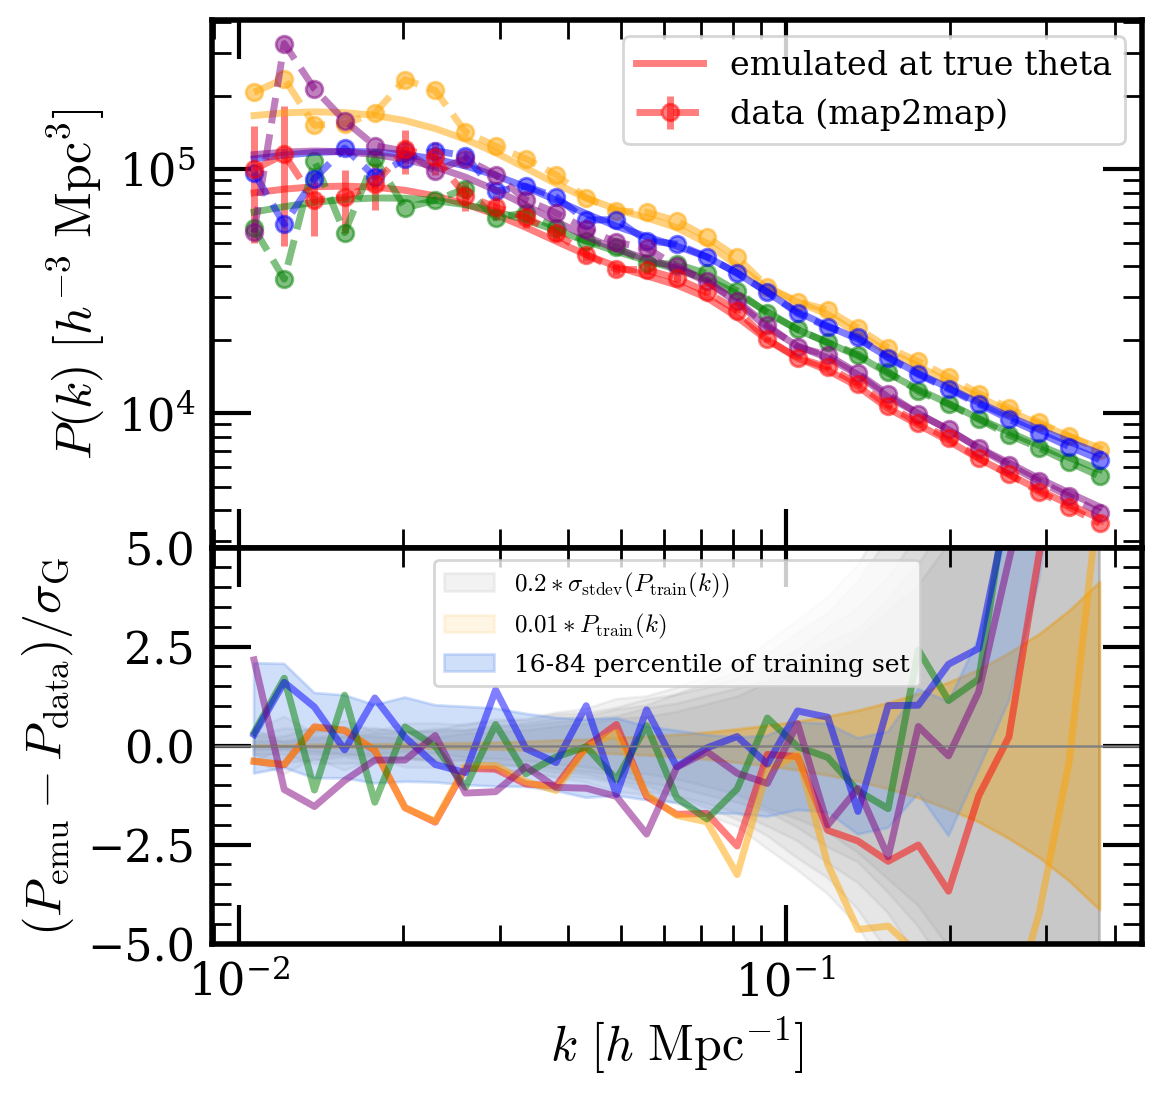

In [43]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,6), sharex=True, height_ratios=[2,1.5])
plt.subplots_adjust(hspace=0)
    
# a few examples
colors = ['red', 'orange', 'green', 'blue', 'purple']
for i in range(5):
    for pp in range(len(param_names)):
        cosmo_params[emu_param_names[pp]] = theta[i][pp]
    _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
                                                        **cosmo_params)

    label_true, label_emu, label_stdev, label_m2m = None, None, None, None
    if i==0:
        label_true = 'data (map2map)'
        label_emu = 'emulated at true theta'
        label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
        label_m2m = r'$0.01*P_\text{train}(k)$'
    
    if i==0:
        axarr[0].errorbar(k, Pk_train[i], yerr=gaussian_error_pk_train[i], 
                          ls='--', marker='o', markersize=6, alpha=0.5, label=label_true, color=colors[i])
    else:
        axarr[0].plot(k, Pk_train[i], ls='--', marker='o', markersize=6, alpha=0.5, label=label_true, color=colors[i])
    axarr[0].plot(k, pk_model_unscaled, ls='-', alpha=0.5, label=label_emu, color=colors[i])
    
    axarr[1].plot(k, (pk_model_unscaled-Pk_train[i])/gaussian_error_pk_train[i], ls='-', alpha=0.5, color=colors[i])
    axarr[1].axhline(0, color='grey', lw=0.5)
    axarr[1].fill_between(k, -err_extra/gaussian_error_pk_train[i], 
                              err_extra/gaussian_error_pk_train[i], color='grey', alpha=0.1,
                              label=label_stdev)

    err_m2m = 0.01*Pk_train[i]
    axarr[1].fill_between(k, -err_m2m/gaussian_error_pk_train[i], 
                              err_m2m/gaussian_error_pk_train[i], color='orange', alpha=0.1,
                              label=label_m2m)


axarr[1].fill_between(k, delta_pk_per_err_16, delta_pk_per_err_84, color='cornflowerblue', alpha=0.3,
                      label='16-84 percentile of training set')

plt.xscale('log')
axarr[0].set_yscale('log')
    
axarr[1].set_ylim(-5, 5)
    
axarr[0].legend(fontsize=12)
axarr[1].legend(fontsize=9)

axarr[1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=18)
axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=18)    
axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=18)


Text(0, 0.5, '$(P_\\text{emu}-P_\\text{data})/\\sigma_\\text{G}$')

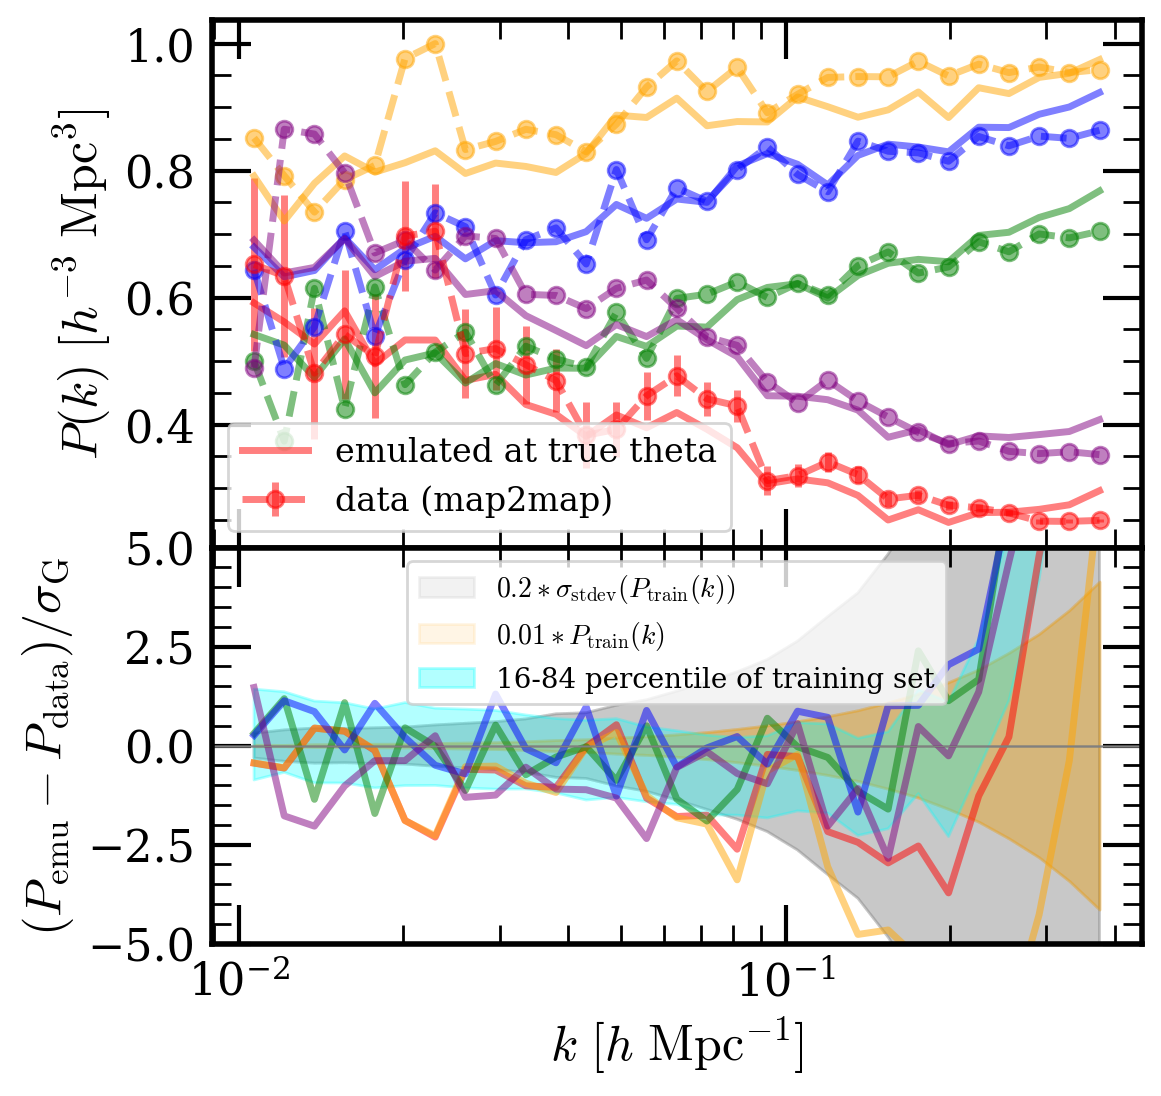

In [44]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,6), sharex=True, height_ratios=[2,1.5])
plt.subplots_adjust(hspace=0)

colors = ['red', 'orange', 'green', 'blue', 'purple']

for i in range(5):
    for pp in range(len(param_names)):
        cosmo_params[emu_param_names[pp]] = theta[i][pp]
    _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
                                                        **cosmo_params)
    pk_model_scaled = scaler.scale(pk_model_unscaled)
    label_true, label_emu, label_stdev, label_m2m = None, None, None, None
    if i==0:
        label_true = 'data (map2map)'
        label_emu = 'emulated at true theta'
        label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
        label_m2m = r'$0.01*P_\text{train}(k)$'
    
    if i==0:
        axarr[0].errorbar(k, Pk_train_scaled[i], yerr=gaussian_error_pk_train_scaled[i], 
                          ls='--', marker='o', markersize=6, alpha=0.5, label=label_true, color=colors[i])
    else:
        axarr[0].plot(k, Pk_train_scaled[i], ls='--', marker='o', markersize=6, alpha=0.5, label=label_true, color=colors[i])
    axarr[0].plot(k, pk_model_scaled, ls='-', alpha=0.5, label=label_emu, color=colors[i])
    
    axarr[1].plot(k, (pk_model_scaled-Pk_train_scaled[i])/gaussian_error_pk_train_scaled[i], ls='-', alpha=0.5, color=colors[i])
    axarr[1].axhline(0, color='grey', lw=0.5)    
    
    axarr[1].fill_between(k, -err_extra_scaled/gaussian_error_pk_train_scaled[i], 
                              err_extra_scaled/gaussian_error_pk_train_scaled[i], color='grey', alpha=0.1,
                              label=label_stdev)
    err_m2m = scaler.scale_error(0.01*Pk_train[i], Pk_train[i])
    axarr[1].fill_between(k, -err_m2m/gaussian_error_pk_train_scaled[i], 
                              err_m2m/gaussian_error_pk_train_scaled[i], color='orange', alpha=0.1,
                              label=label_m2m)
    
axarr[1].fill_between(k, deltas_pk_per_err_scaled_16, deltas_pk_per_err_scaled_84, color='cyan', alpha=0.3,
                      label='16-84 percentile of training set')

plt.xscale('log')
#axarr[0].set_yscale('log')
    
axarr[1].set_ylim(-5, 5)
    
axarr[0].legend(fontsize=12)
axarr[1].legend(fontsize=10)

axarr[1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=18)
axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=18)    
axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=18)


### Set up and run Moment Network model

Following demos at https://github.com/NiallJeffrey/MomentNetworks/tree/master

In [45]:
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.layers import Dense, Dropout, ReLU, LeakyReLU, Input

class neural_net():
    """
    A simple MLP with LeakyReLU activation
    """
    
    def __init__(self, input_size, output_size, 
                 hidden_size=32, learning_rate=None,
                 activation='leakyrelu',
                 alpha=0.1):
        """
        Initialisation
        :param map_size: size of square image (there are map_size**2 pixels)
        :param learning_rate: learning rate for the optimizer
        """
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.output_size = output_size
        self.hidden_size = hidden_size
        if activation=='leakyrelu':
            self.activation_func = LeakyReLU
            self.activation_kwargs = {'alpha': alpha}
        elif activation=='relu':
            self.activation_func = ReLU
            self.activation_kwargs = {}
        else:
            raise ValueError(f"Activation function {activation} not recognized")

        
    def model(self):
        print(self.input_size)
        
        input_data = (Input(shape=(self.input_size,)))

        x1 = Dense(self.hidden_size, input_dim=self.input_size, kernel_initializer='normal')(input_data)
        x1 = self.activation_func(**self.activation_kwargs)(x1)
        x2 = Dense(self.hidden_size, kernel_initializer='normal')(x1)
        x2 = self.activation_func(**self.activation_kwargs)(x2)
        x3 = Dense(self.hidden_size, kernel_initializer='normal')(x2)
        x3 = self.activation_func(**self.activation_kwargs)(x3)
        #x4 = Dense(self.output_size, kernel_initializer='normal', activation='relu')(x3)        
        x4 = Dense(self.output_size, kernel_initializer='normal')(x3)        

        dense_model = Model(input_data, x4)
        dense_model.summary()

        if self.learning_rate is None:
            dense_model.compile(optimizer='adam', loss='mse')
        else:
            dense_model.compile(optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate), loss='mse')

        return dense_model

In [54]:
if run_moment:
    model_instance = neural_net(n_dim, n_params, 
                                hidden_size=64,
                                learning_rate=1e-3) 
    regression = model_instance.model()

29
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense (Dense)               (None, 64)                1920      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)                0  

In [55]:
print(theta_train.shape, Pk_train.shape)
print(theta_val.shape, Pk_val.shape)

(400, 3) (400, 29)
(50, 3) (50, 29)


Train initial model (basic MLP), as usual, on labeled data

In [56]:
if run_moment:
    callback = tf.keras.callbacks.EarlyStopping(patience=25,
                                restore_best_weights=True,
                                start_from_epoch=200)
    history = regression.fit(Pk_train_scaled, theta_train,
                            epochs=2500, batch_size=64, shuffle=True,
                            callbacks=[callback],
                            validation_data=(Pk_val_scaled, theta_val))

Epoch 1/2500
7/7 [==============================] - 2s 95ms/step - loss: 0.3872 - val_loss: 0.3569
Epoch 2/2500
7/7 [==============================] - 0s 65ms/step - loss: 0.3201 - val_loss: 0.2486
Epoch 3/2500
7/7 [==============================] - 1s 107ms/step - loss: 0.1827 - val_loss: 0.0854
Epoch 4/2500
7/7 [==============================] - 1s 97ms/step - loss: 0.0706 - val_loss: 0.0700
Epoch 5/2500
7/7 [==============================] - 1s 75ms/step - loss: 0.0465 - val_loss: 0.0387
Epoch 6/2500
7/7 [==============================] - 0s 56ms/step - loss: 0.0390 - val_loss: 0.0409
Epoch 7/2500
7/7 [==============================] - 1s 93ms/step - loss: 0.0346 - val_loss: 0.0328
Epoch 8/2500
7/7 [==============================] - 1s 84ms/step - loss: 0.0287 - val_loss: 0.0291
Epoch 9/2500
7/7 [==============================] - 1s 104ms/step - loss: 0.0258 - val_loss: 0.0270
Epoch 10/2500
7/7 [==============================] - 1s 121ms/step - loss: 0.0238 - val_loss: 0.0245
Epoch 

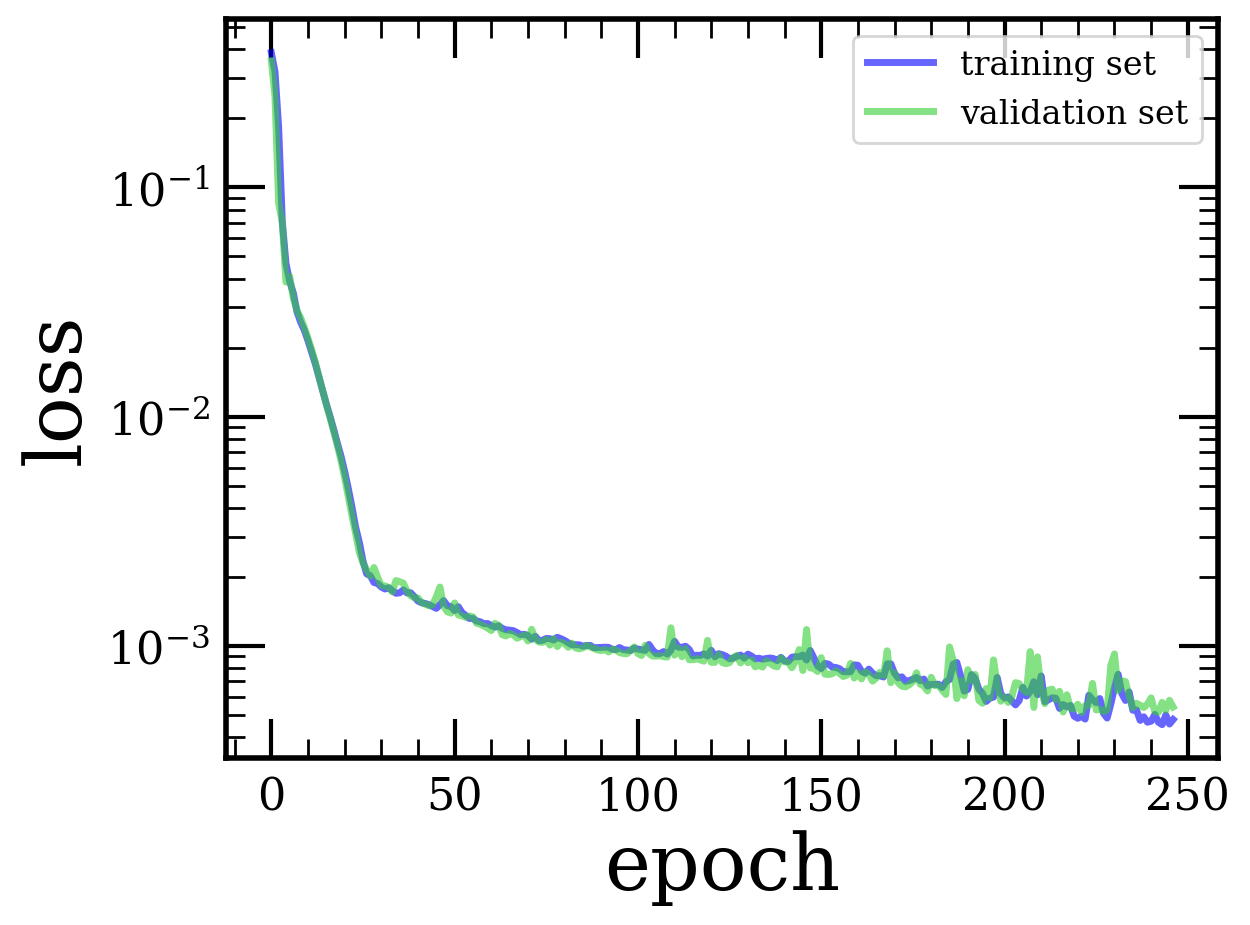

In [58]:
if run_moment:

    plt.plot(history.history['loss'], color='blue', label='training set', alpha=0.6)
    plt.plot(history.history['val_loss'], color='limegreen', label='validation set', alpha=0.6)
    plt.legend(fontsize=12)
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.yscale('log')
    #plt.ylim(0, 0.005)

In [59]:
if run_moment:
    theta_train_pred = regression.predict(np.atleast_2d(Pk_train_scaled))
    theta_val_pred = regression.predict(np.atleast_2d(Pk_val_scaled))
    theta_test_pred = regression.predict(np.atleast_2d(Pk_test_scaled))

2/2 [==============================] - 0s 5ms/step


Get means and residuals

In [60]:
include_covariances = True
if run_moment:
    cov_dict = {}

    covariances_train = []
    covariances_val = []
    covariances_test = []
    count = 0
    for i in range(n_params):
        for j in range(n_params):
            if not include_covariances:
                if i!=j:
                    continue
                
            if j<i:
                cov_dict[(i,j)] = cov_dict[(j,i)]
                continue
                
            covariances_train.append((theta_train[:,i]-theta_train_pred[:,i])* \
                            (theta_train[:,j]-theta_train_pred[:,j]))
                        
            covariances_val.append((theta_val[:,i]-theta_val_pred[:,i])* \
                                (theta_val[:,j]-theta_val_pred[:,j]))
            
            covariances_test.append((theta_test[:,i]-theta_test_pred[:,i])* \
                                 (theta_test[:,j]-theta_test_pred[:,j]))
            
            cov_dict[(i,j)] = count
            count += 1
            
    covariances_train = np.array(covariances_train).T
    covariances_val = np.array(covariances_val).T
    covariances_test = np.array(covariances_test).T

    n_covs = covariances_train.shape[1]

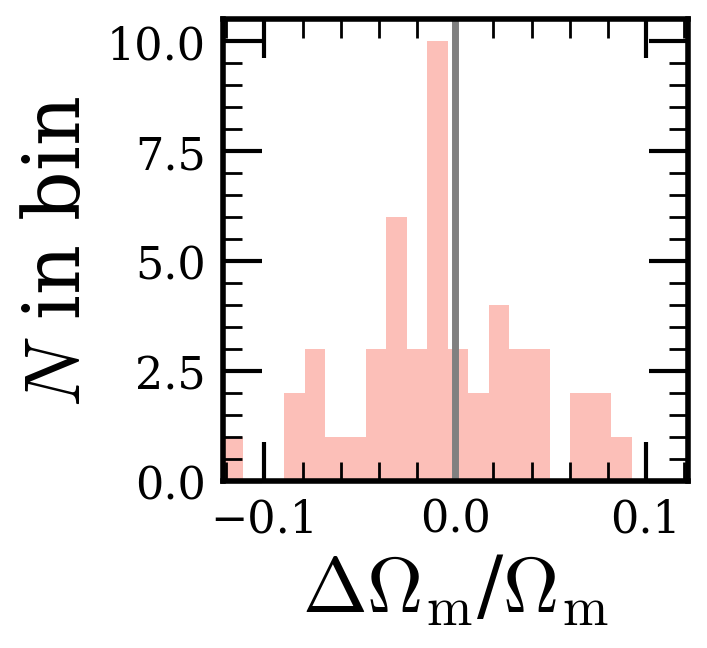

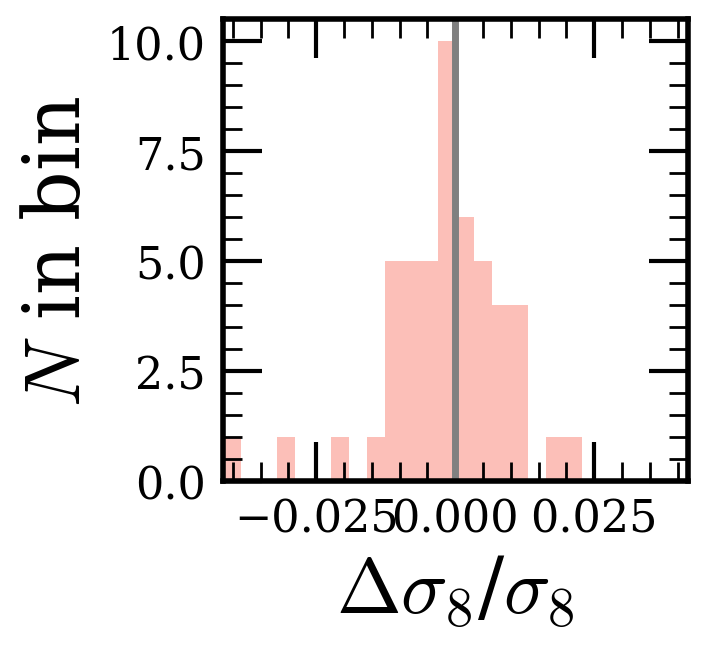

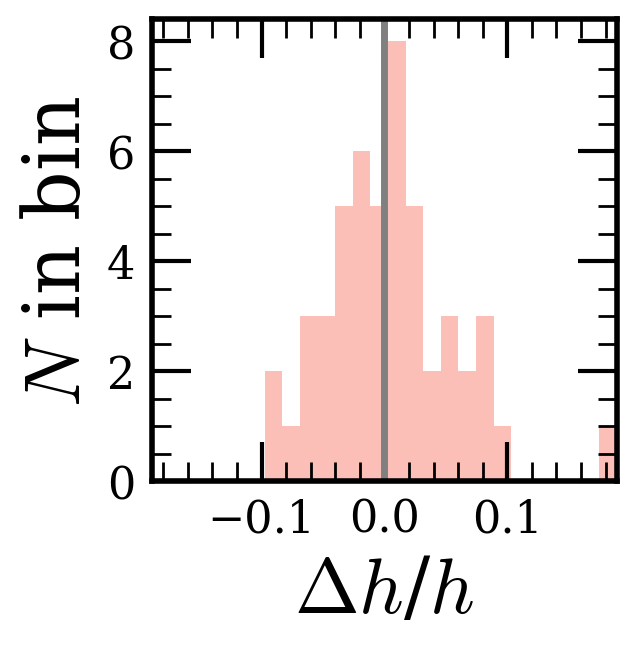

In [61]:
if run_moment:
    for pp in range(n_params):
        plt.figure(figsize=(3,3))
        #delta_param = (theta_train_pred[:,pp] - theta_train[:,pp])/theta_train[:,pp]
        delta_param = (theta_test_pred[:,pp] - theta_test[:,pp])/theta_test[:,pp]
        plt.hist(delta_param, bins=20, alpha=0.5, color='salmon')
        plt.xlabel(rf'$\Delta${param_labels[pp]}/{param_labels[pp]}')
        plt.ylabel(r'$N$ in bin')
        plt.axvline(0, color='grey')
        plt.xlim(-np.max(abs(delta_param)), np.max(abs(delta_param)))

Set up and train model on the residuals

In [62]:
scaler_cov = Scaler(func='minmax')
scaler_cov.fit(covariances_train)
covariances_train_scaled = scaler_cov.scale(covariances_train)
covariances_val_scaled = scaler_cov.scale(covariances_val)
covariances_test_scaled = scaler_cov.scale(covariances_test)

In [63]:
if run_moment:
    model_instance = neural_net(n_dim, n_covs, 
                                hidden_size=64,
                                learning_rate=1e-2,
                                activation='leakyrelu',
                                alpha=0.1)
    regression_var_unknown_mean = model_instance.model()

29
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_4 (Dense)             (None, 64)                1920      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64)                0

In [64]:
if run_moment:
    
    callback = tf.keras.callbacks.EarlyStopping(patience=20,
                                restore_best_weights=True,
                                start_from_epoch=100)
    
    history_var = regression_var_unknown_mean.fit(Pk_train_scaled,
                                            covariances_train_scaled,
                                            epochs=500, batch_size=64, shuffle=True,
                                            callbacks=[callback],
                                            validation_data = (Pk_val_scaled,
                                                                covariances_val_scaled))

Epoch 1/500
7/7 [==============================] - 1s 119ms/step - loss: 0.2022 - val_loss: 0.1998
Epoch 2/500
7/7 [==============================] - 1s 93ms/step - loss: 0.1737 - val_loss: 0.1491
Epoch 3/500
7/7 [==============================] - 1s 108ms/step - loss: 0.1090 - val_loss: 0.0602
Epoch 4/500
7/7 [==============================] - 1s 97ms/step - loss: 0.0474 - val_loss: 0.0491
Epoch 5/500
7/7 [==============================] - 1s 113ms/step - loss: 0.0389 - val_loss: 0.0351
Epoch 6/500
7/7 [==============================] - 0s 63ms/step - loss: 0.0334 - val_loss: 0.0376
Epoch 7/500
7/7 [==============================] - 1s 149ms/step - loss: 0.0315 - val_loss: 0.0323
Epoch 8/500
7/7 [==============================] - 1s 119ms/step - loss: 0.0290 - val_loss: 0.0307
Epoch 9/500
7/7 [==============================] - 1s 100ms/step - loss: 0.0271 - val_loss: 0.0292
Epoch 10/500
7/7 [==============================] - 0s 59ms/step - loss: 0.0260 - val_loss: 0.0272
Epoch 11/500


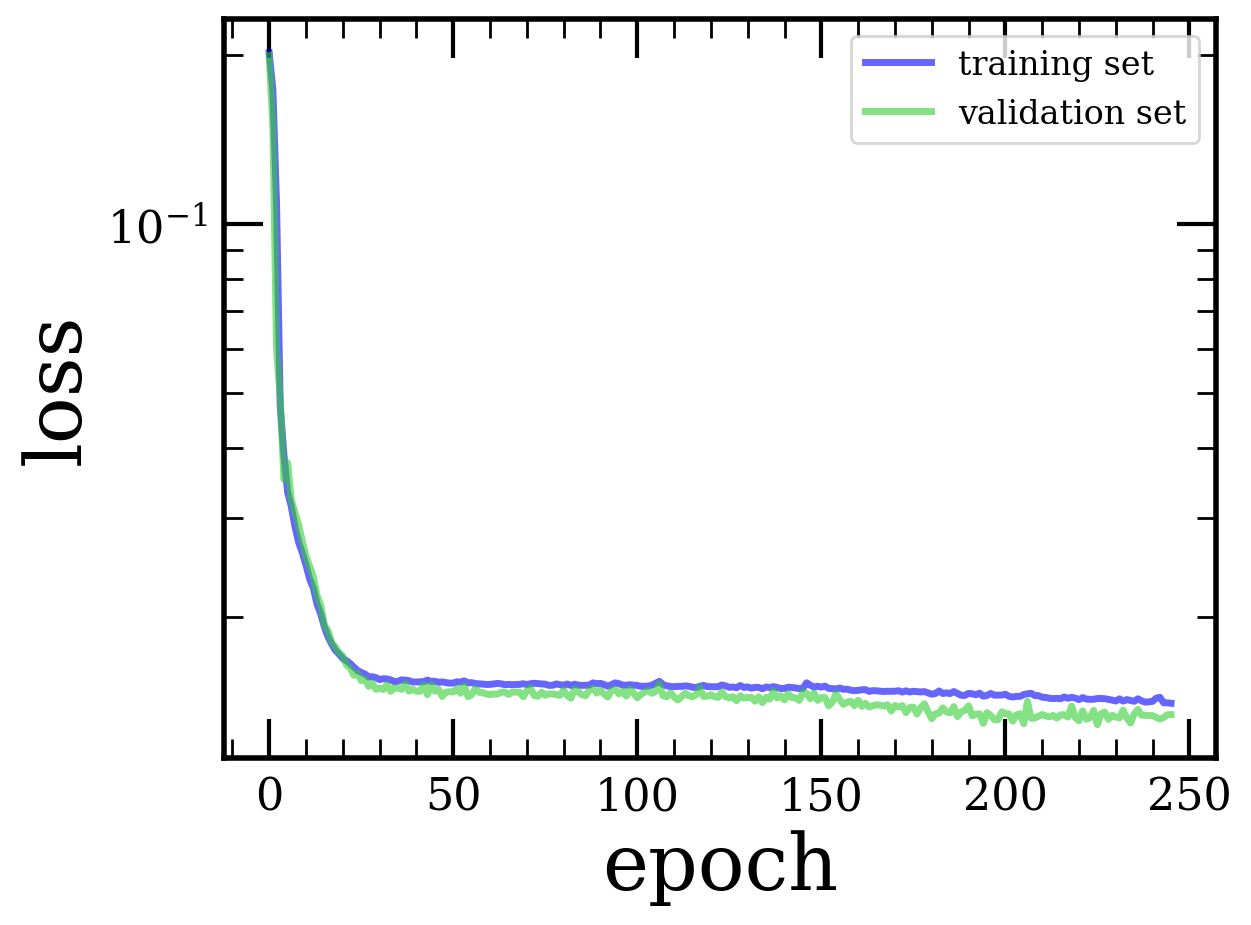

In [65]:
if run_moment:
    plt.plot(history_var.history['loss'], color='blue', label='training set', alpha=0.6)
    plt.plot(history_var.history['val_loss'], color='limegreen', label='validation set', alpha=0.6)
    plt.legend(fontsize=12)
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.yscale('log')
    #plt.ylim(0, 0.005)

### SBI

In [161]:
# TODO deal with validation fraction being taken from training set set
inference, posterior = sbi_tools.train_model(
    theta_train,
    Pk_train_scaled,
    prior=sbi_tools.get_prior(dict_bounds),
    training_batch_size=32,
    learning_rate=1e-3,
    validation_fraction=0.1
)

 Neural network successfully converged after 60 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 60
        Best validation performance: 7.7281
        -------------------------
        


### Set up explicit likelihood, MCMC

In [80]:
# for emcee
n_burn = 100
n_steps = 600 # 50000
n_walkers = 4 * n_params

In [81]:
# for emcee
def log_prior(theta):
    for pp in range(len(param_names)):
       if (theta[pp] < dict_bounds[param_names[pp]][0]) or (theta[pp] >= dict_bounds[param_names[pp]][1]):
           return -np.inf
    return 0.0

# for dynesty
def prior_transform(u):

    u_transformed = []
    for pp in range(len(param_names)):
        width = dict_bounds[param_names[pp]][1] - dict_bounds[param_names[pp]][0]
        min_bound = dict_bounds[param_names[pp]][0]
        
        u_t = width*u[pp] + min_bound
        u_transformed.append(u_t)           

    return np.array(u_transformed)

In [82]:
global pk_data, cov_inv

def log_likelihood(theta):
    for pp in range(len(param_names)):
        cosmo_params[emu_param_names[pp]] = theta[pp]
    _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
                                                **cosmo_params)
    pk_model = scaler.scale(pk_model_unscaled)
    diff = pk_data-pk_model
    # print(theta)
    # print(cosmo_params)
    # print(pk_data)
    # print(pk_model)
    # print(cov_inv[0,0], cov_inv[1,1], cov_inv[2,2])
    # print(-0.5*np.dot(diff,np.dot(cov_inv,diff)))
    
    # print()
    return -0.5*np.dot(diff,np.dot(cov_inv,diff))

def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

### Test on a model from the test set (held-out data)

Moment network:

In [78]:
if run_moment:

    predicted_mean_obs_test = regression.predict(np.atleast_2d(pk_data))
    print(predicted_mean_obs_test)

    predicted_var_obs_test_scaled = (regression_var_unknown_mean.predict(np.atleast_2d(pk_data))[0])
    predicted_var_obs_test = scaler_cov.unscale(predicted_var_obs_test_scaled)

    moment_network_param_cov_test = np.zeros((n_params, n_params))
    for i in range(n_params):
        for j in range(n_params):
            if not include_covariances:
                if i!=j:
                    continue
            moment_network_param_cov_test[i,j] = predicted_var_obs_test[cov_dict[(i,j)]]
    print(moment_network_param_cov_test)

    moment_network_samples_test = np.array(np.random.multivariate_normal(predicted_mean_obs_test[0],
                                        moment_network_param_cov_test,int(1e6)),dtype=np.float32)
    gc.collect()

1/1 [==============================] - 0s 26ms/step
[[0.2532345 0.7871166 0.6605735]]
1/1 [==============================] - 0s 28ms/step
[[ 1.36510639e-04  8.92291845e-06 -2.18378309e-04]
 [ 8.92291845e-06  2.88633684e-05 -1.30505361e-05]
 [-2.18378309e-04 -1.30505361e-05  1.15587572e-03]]


SBI

In [167]:
samples_sbi_test = sbi_tools.sample_posteriors_theta_test(
    posterior,
    np.atleast_2d(pk_data),
    dict_bounds,
    N_samples=10000
)[0]

0


Drawing 10000 posterior samples: 10298it [00:00, 36310.14it/s]                          


Explicit likelihood setup

In [83]:
err_gaussian_scaled = gaussian_error_pk_test_scaled[idx_test]
#var = err_gaussian_scaled**2
#var = err_gaussian_scaled**2 + err_extra_scaled**2

err_m2m = scaler.scale_error(0.01*pk_data, pk_data)
var = err_gaussian_scaled**2 + err_m2m**2

cov_inv = np.diag(1/var)

n_threads = 24


MCMC, Dynesty:

In [91]:
n_threads = 16
if run_dynesty:
    with dynesty.pool.Pool(n_threads, log_likelihood, prior_transform) as pool:
        sampler_test = dynesty.NestedSampler(pool.loglike, pool.prior_transform, n_params, 
                                            nlive=20, bound='single')
        sampler_test.run_nested(dlogz=0.01)

257it [02:20,  1.84it/s, +20 | bound: 33 | nc: 1 | ncall: 1703 | eff(%): 16.459 | loglstar:   -inf < -18.754 <    inf | logz: -26.661 +/-  0.559 | dlogz:  0.000 >  0.010]


In [92]:
if run_dynesty:
    results_test = sampler_test.results
    samples_dynesty_test = results_test.samples_equal()
    print(samples_dynesty_test.shape)

(277, 3)


MCMC, emcee:

In [89]:
n_threads = 4
if run_emcee:
    rng = np.random.default_rng(seed=42)
    theta_0 = np.array([[rng.uniform(low=dict_bounds[param_name][0],high=dict_bounds[param_name][1]) 
                        for param_name in param_names] for _ in range(n_walkers)])

    start = time.time()
    if n_threads>1:
        with Pool(processes=n_threads) as pool:
            sampler_emcee = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, pool=pool)
            _ = sampler_emcee.run_mcmc(theta_0, n_steps, progress=True) 
    else:
        sampler_emcee = emcee.EnsembleSampler(n_walkers, n_params, log_posterior)
        _ = sampler_emcee.run_mcmc(theta_0, n_steps, progress=True) 
    end = time.time()

    print(f"Time: {end-start} s ({(end-start)/60} min)")

    samples_emcee = sampler_emcee.get_chain(discard=n_burn, flat=True, thin=1)
    gc.collect()

OMP: Error #34: System unable to allocate necessary resources for OMP thread:
OMP: System error #11: Resource temporarily unavailable
OMP: Hint Try decreasing the value of OMP_NUM_THREADS.


KeyboardInterrupt: 

### Plot contours

In [ ]:
extents = [dict_bounds[param_name] for param_name in param_names]

In [103]:
def plot_contours(extents={}, plot_moment=True, plot_sbi=True, plot_emcee=True, plot_dynesty=True):

    c = chainconsumer.ChainConsumer()

    if run_moment and plot_moment:
        c.add_chain(chainconsumer.Chain(
                    samples=pd.DataFrame(moment_network_samples_test, columns=param_names),
                    name='Moment Network', color='blue')
                    )

    if run_sbi and plot_sbi:
        c.add_chain(chainconsumer.Chain(
                    samples=pd.DataFrame(samples_sbi_test, columns=param_names),
                    name='SBI', color='orange',
                    smooth=1, bins=10)
                    )

    if run_emcee and plot_emcee:
        c.add_chain(chainconsumer.Chain(
                    samples=pd.DataFrame(samples_emcee, columns=param_names),
                    name='MCMC (emcee)', color='purple', ls='--',
                    smooth=2, bins=10)
                    )

    if run_dynesty and plot_dynesty:
        c.add_chain(chainconsumer.Chain(
                    samples=pd.DataFrame(samples_dynesty_test, columns=param_names),
                    name='MCMC (Dynesty)', color='green', 
                    smooth=1, bins=5)
                    )

    c.set_plot_config(
        chainconsumer.PlotConfig(
            flip=True,
            labels=param_label_dict,
            contour_label_font_size=12,
            extents=extents,
        )
    )

    truth_loc = dict(zip(param_names, theta_test[idx_test]))
    c.add_truth(chainconsumer.Truth(location=truth_loc))

    #fig = c.plotter.plot(figsize = (5,4) )
    fig = c.plotter.plot(figsize = (5,5) )
    
    if save_plots:
        plt.savefig(f'{plot_dir}/contours_test{idx_test}{tag_pk}{tag_fit}.png')
        
    plt.show()

In [69]:
theta_test[idx_test]

array([0.29096719, 0.79635278, 0.72309242])

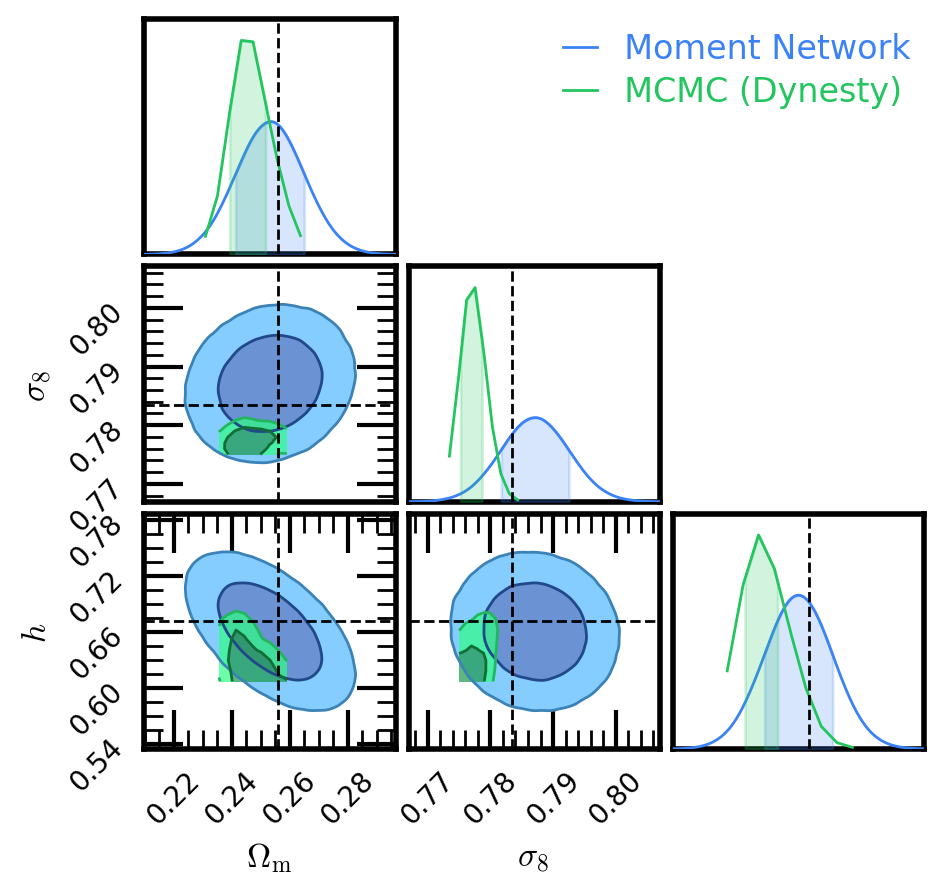

In [104]:
plot_contours()

Saved figure as ../plots/plots_2024-03-11/contours_test29_b1000_cosmolib_err1p_kmax0.1.png


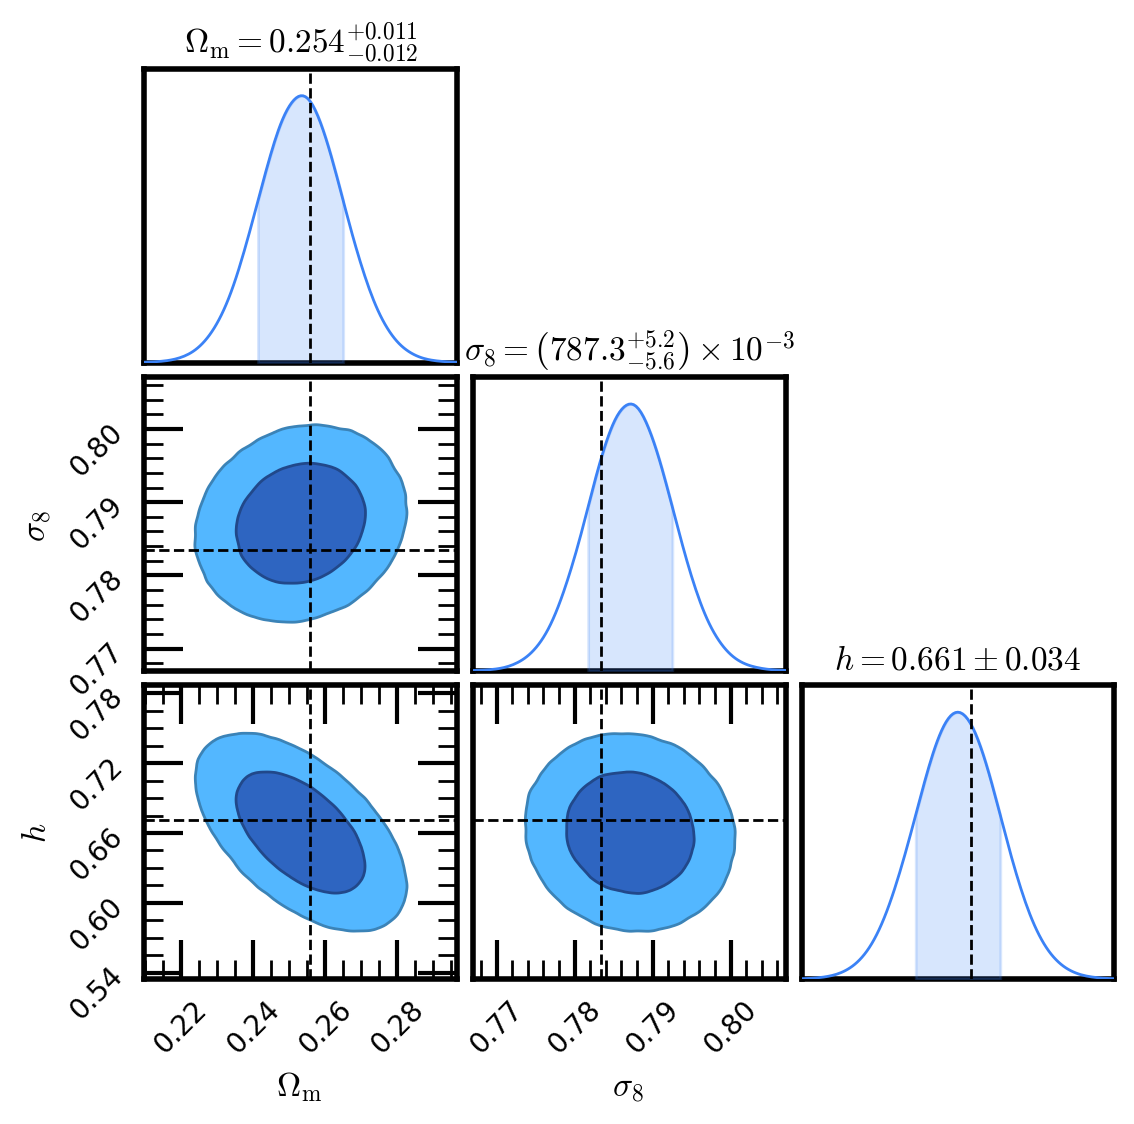

In [79]:
plot_contours(plot_dynesty=False)

Saved figure as ../plots/plots_2024-02-19/contours_test0_b1000_cosmolib_err1p_kmax0.1_priorbounds.png


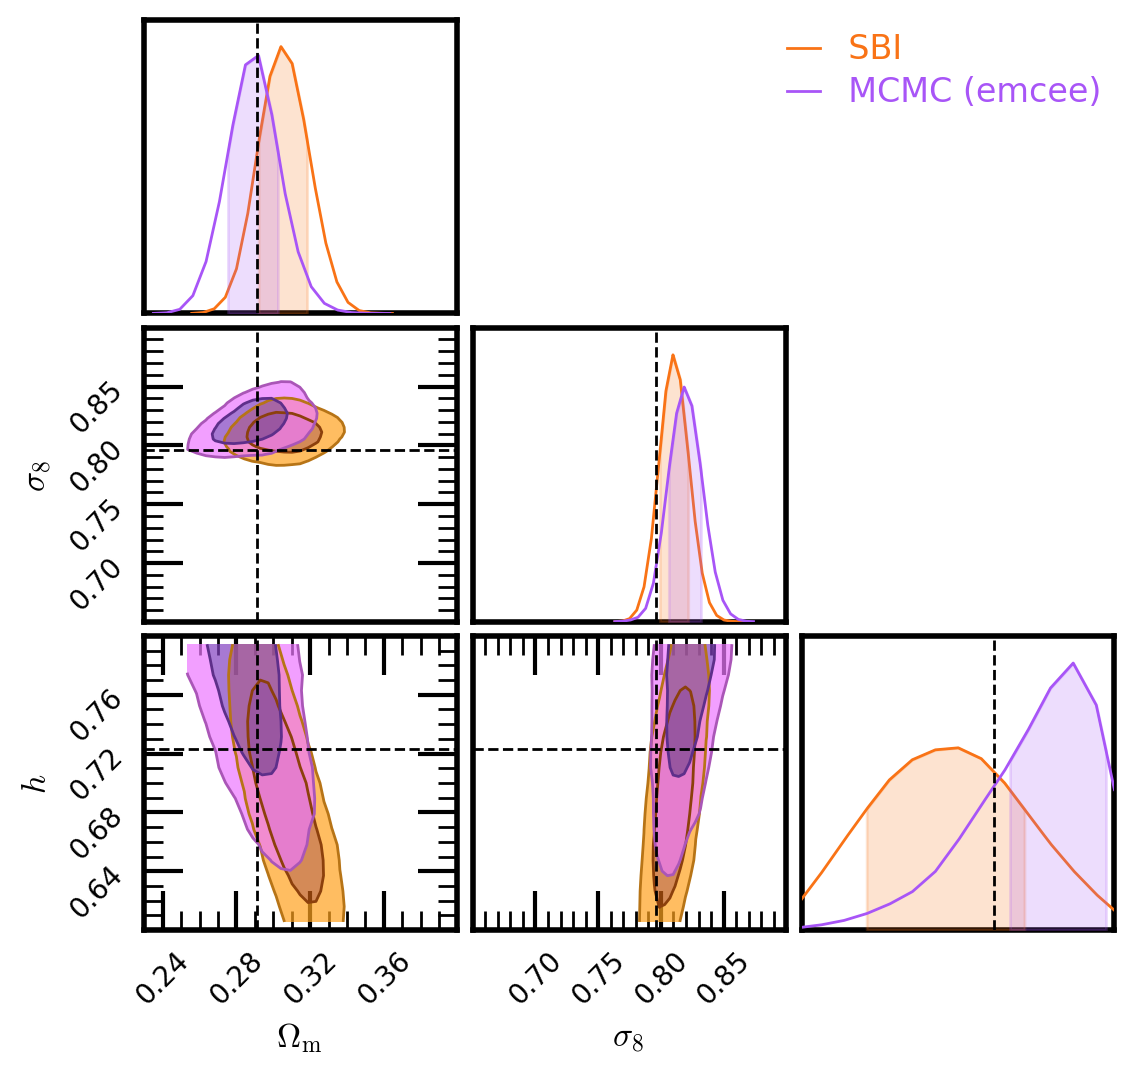

In [175]:
plot_contours(extents=dict_bounds)

#### All test set 

In [176]:
samples_sbi_test_all = sbi_tools.sample_posteriors_theta_test(
    posterior,
    Pk_test_scaled,
    dict_bounds,
    N_samples=10000
)[0]

0


Drawing 10000 posterior samples: 10305it [00:00, 39766.55it/s]                          
Drawing 10000 posterior samples: 10384it [00:00, 49537.48it/s]                          
Drawing 10000 posterior samples: 10339it [00:00, 55486.49it/s]                          
Drawing 10000 posterior samples: 10498it [00:00, 52110.68it/s]                          
Drawing 10000 posterior samples: 10461it [00:00, 48475.38it/s]                          
Drawing 10000 posterior samples: 10394it [00:00, 51113.95it/s]                          
Drawing 10000 posterior samples: 10557it [00:00, 39605.82it/s]                          
Drawing 10000 posterior samples: 10932it [00:00, 57416.00it/s]                          
Drawing 10000 posterior samples: 11854it [00:00, 49090.87it/s]                          
Drawing 10000 posterior samples: 10629it [00:00, 49151.46it/s]                          
Drawing 10000 posterior samples: 10429it [00:00, 56036.96it/s]                          
Drawing 10000 posteri

20


Drawing 10000 posterior samples: 11185it [00:00, 47102.31it/s]                          
Drawing 10000 posterior samples: 10309it [00:00, 70974.03it/s]                          
Drawing 10000 posterior samples: 10528it [00:00, 56551.30it/s]                          
Drawing 10000 posterior samples: 11064it [00:00, 54702.51it/s]                          
Drawing 10000 posterior samples: 11745it [00:00, 40663.25it/s]                          
Drawing 10000 posterior samples: 11076it [00:00, 53856.41it/s]                          
Drawing 10000 posterior samples: 11553it [00:00, 69235.86it/s]                          
Drawing 10000 posterior samples: 10850it [00:00, 59163.18it/s]                          
Drawing 10000 posterior samples: 10405it [00:00, 48539.25it/s]                          
Drawing 10000 posterior samples: 10584it [00:00, 55939.98it/s]                          
Drawing 10000 posterior samples: 10648it [00:00, 63381.77it/s]                          
Drawing 10000 posteri

40


Drawing 10000 posterior samples: 11003it [00:00, 56887.43it/s]                          
Drawing 10000 posterior samples: 10370it [00:00, 77401.93it/s]                          
Drawing 10000 posterior samples: 10336it [00:00, 53758.93it/s]                          
Drawing 10000 posterior samples: 10365it [00:00, 52802.66it/s]                          
Drawing 10000 posterior samples: 10768it [00:00, 54272.88it/s]                          
Drawing 10000 posterior samples: 10557it [00:00, 61560.54it/s]                          
Drawing 10000 posterior samples: 10340it [00:00, 66586.07it/s]                          
Drawing 10000 posterior samples: 11452it [00:00, 48635.62it/s]                          
Drawing 10000 posterior samples: 10737it [00:00, 52202.30it/s]                          
Drawing 10000 posterior samples: 10992it [00:00, 48597.57it/s]                          


### Moment network, all test

In [70]:
sigmas_from_truth = []
sigmas_total = []

theta_test_pred = regression.predict(Pk_test_scaled)
vars_test_pred_scaled = regression_var_unknown_mean.predict(Pk_test_scaled)
vars_test_pred = scaler_cov.unscale(vars_test_pred_scaled)
#print(theta_pred_test.shape, vars_pred_test.shape)

for i in range(Pk_test_scaled.shape[0]):
    pk_data_test = Pk_test_scaled[i]
    
    moment_network_param_cov_test = np.zeros((n_params, n_params))
    for ii in range(n_params):
        for jj in range(n_params):
            if not include_covariances:
                if ii!=jj:
                    continue
            moment_network_param_cov_test[ii,jj] = vars_test_pred[i][cov_dict[(ii,jj)]]

    err = np.sqrt(np.diag(moment_network_param_cov_test))
    sigma_from_truth = (theta_test_pred[i] - theta_test[i])/err
    sigmas_from_truth.append(sigma_from_truth)
    
    diff = theta_test_pred[i] - theta_test[i]
    cov_pred_inv = np.linalg.inv(moment_network_param_cov_test)
    sigma_total = diff.T @ cov_pred_inv @ diff
    sigmas_total.append(sigma_total)

sigmas_from_truth = np.array(sigmas_from_truth)
sigmas_total = np.array(sigmas_total)



2/2 [==============================] - 0s 2ms/step


In [72]:
print(np.sum((theta_test_pred - theta_test)/theta_test, axis=1).shape)
idxs_test_orderedchi2 = np.argsort(sigmas_total)
print(np.where(idxs_test_orderedchi2==idx_test)[0])
idx_test_goodchi2 = idxs_test_orderedchi2[10]
print(idx_test, sigmas_total[idx_test], theta_test[idx_test], theta_test_pred[idx_test])
print(idx_test_goodchi2, sigmas_total[idx_test_goodchi2], theta_test[idx_test_goodchi2], theta_test_pred[idx_test_goodchi2])

(50,)
[0]
0 -2.992184231379536 [0.29096719 0.79635278 0.72309242] [0.2977517 0.7971688 0.6899464]
29 0.8713068777351151 [0.25587782 0.78340148 0.67135404] [0.2532345 0.7871166 0.6605735]


In [73]:
# idx_nan = (vars_test_pred[:,0] < 0) | (vars_test_pred[:,2] < 0)
# print(np.sum(idx_nan))

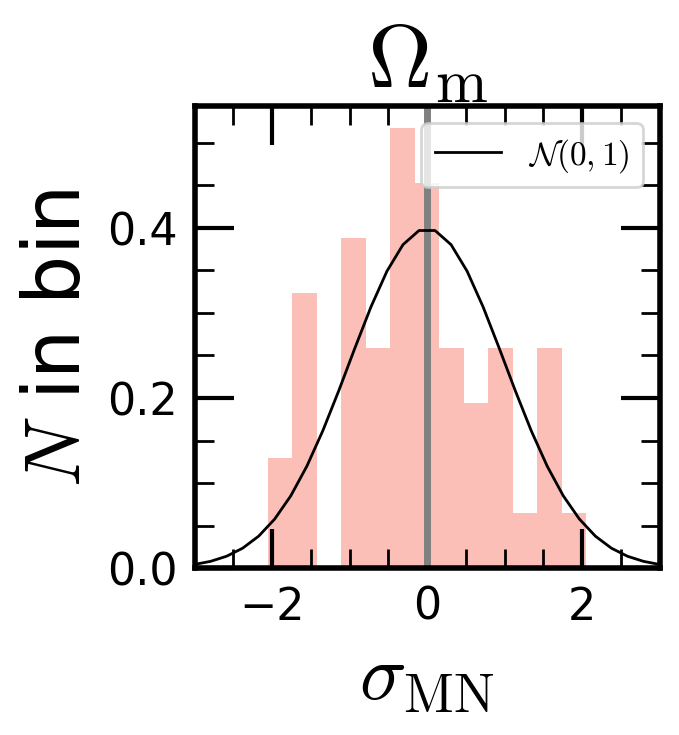

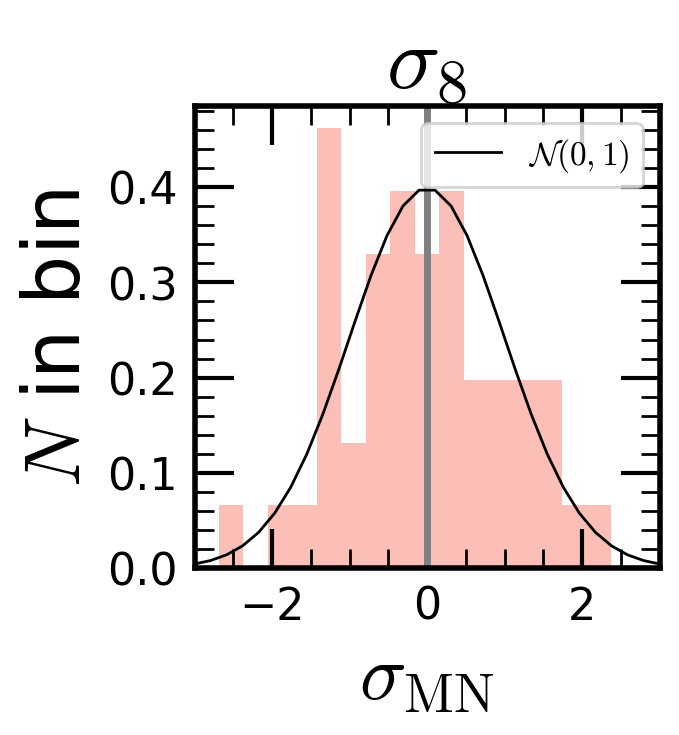

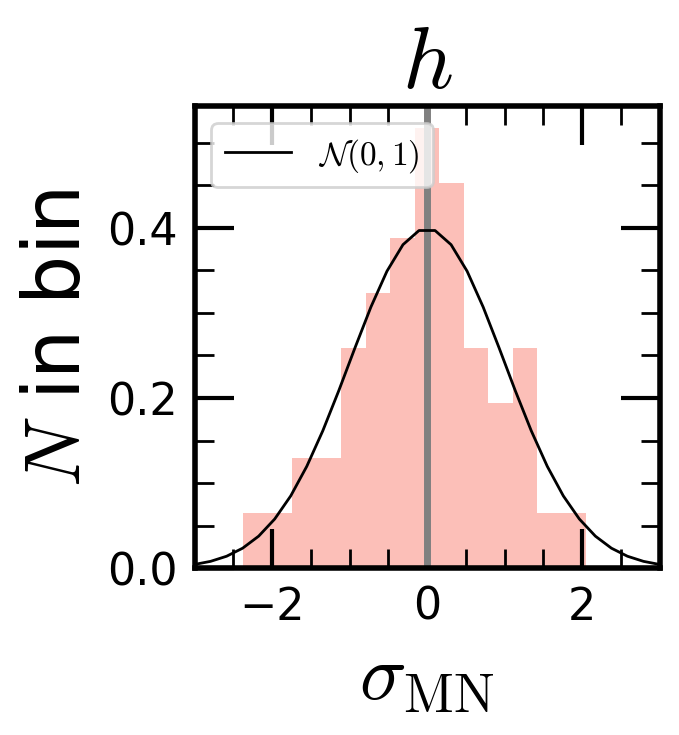

In [74]:
x_normal = np.linspace(-3, 3, 30)
mean, variance = 0, 1
y_normal = np.exp(-np.square(x_normal-mean)/2*variance)/(np.sqrt(2*np.pi*variance))
#xmin, xmax = -np.max(abs(sigmas_from_truth[:,pp])[~idx_nan]), np.max(abs(sigmas_from_truth[:,pp])[~idx_nan])
xmin, xmax = -3, 3
for pp in range(n_params):
    plt.figure(figsize=(3,3))
    plt.title(rf'{param_labels[pp]}')
    plt.hist(sigmas_from_truth[:,pp], bins=np.linspace(xmin, xmax, 20),
             color='salmon', alpha=0.5, density=True)
    plt.xlabel(r'$\sigma_\text{MN}$')
    plt.ylabel(r'$N$ in bin')

    plt.axvline(0, color='grey')
    
    plt.xlim(xmin, xmax)
    plt.plot(x_normal, y_normal, color='black', lw=1, label=r'$\mathcal{N}(0,1)$')
    plt.legend(fontsize=12)

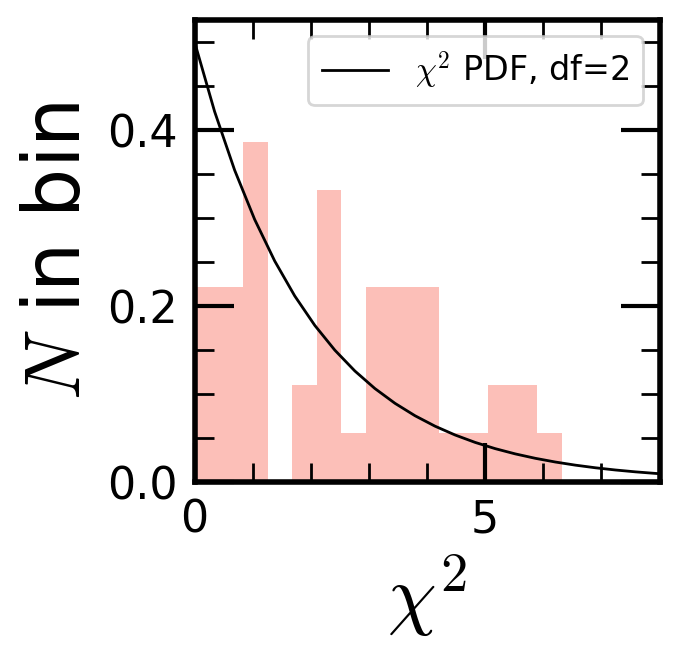

In [75]:
from scipy.stats import chi2

x_normal = np.linspace(0, 10, 30)
mean, variance = 0, 1
y_normal = np.exp(-np.square(x_normal-mean)/2*variance)/(np.sqrt(2*np.pi*variance))
#xmin, xmax = -np.max(abs(sigmas_from_truth[:,pp])[~idx_nan]), np.max(abs(sigmas_from_truth[:,pp])[~idx_nan])
xmin, xmax = 0, 8

plt.figure(figsize=(3,3))
plt.xlabel(r'$\chi^2$')
plt.ylabel(r'$N$ in bin')
plt.hist(sigmas_total, bins=np.linspace(xmin, xmax, 20), color='salmon', alpha=0.5, density=True)
df = 2
plt.plot(x_normal, chi2.pdf(x_normal, df), color='black', lw=1, label=rf'$\chi^2$ PDF, df={df}')

plt.xlim(xmin, xmax)
plt.legend(fontsize=12)
#plt.plot(x_normal, y_normal, color='black', lw=1)